In [ ]:
"""
Copyright (c) Frederik Benzing
All rights reserved.

MIT License

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
def make_patterns_labels(size, number):
    return -1+2*np.random.randint(2, size=(number,size)), -1+2*np.random.randint(2, size=[number])

class perceptron:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros(size)
        
    def evaluate(self, patterns, labels):
        correct = 0
        pattern_num = len(labels)
        for i in range(pattern_num):
            prediction = -1 + 2*(np.matmul(patterns[i,:],self.weights) >= 0)
            correct += (prediction == labels[i])
            #print(prediction)
        return correct/pattern_num
        
    def update(self, pattern, label):
        prediction = -1 + 2*(np.matmul(pattern,self.weights) >= 0)
        self.weights += (label - prediction) * pattern
        
        
class perceptron_batch(perceptron):
    def __init__(self, size):
        super().__init__(size)
        
    def update(self, patterns, labels):
        predictions = -1 + 2*(np.matmul(patterns, self.weights) >= 0)
        diff = np.expand_dims(labels - predictions,axis=1)
        updates = diff * patterns
        self.weights += updates.mean(axis=0)
        

class perceptron_probabilistic(perceptron_batch):
    def __init__(self, size, g_thresh=0.2, diff=0.05):
        super().__init__(size)
        self.p_low = 0.25
        self.p_up = 0.9
        self.p_diff = diff
        self.g_thresh = g_thresh
        self.probs = self.p_low * np.ones(size)
        self.frozen = np.zeros(size)
        
    def evaluate(self, patterns, labels):
        n_evals = 10
        if False:
            correct = 0
            pattern_num = len(labels)
            for i in range(pattern_num):
                total_pred = 0
                for j in range(n_evals):
                    sample = np.random.binomial(1, self.probs)
                    prediction = -1 + 2*(np.matmul(patterns[i,:], sample*self.weights/self.probs) >=0)
                    total_pred += prediction
                correct += (total_pred*labels[i] >= 0) #check if same sign
                #print(prediction)
                return correct/pattern_num
        total_preds = np.zeros_like(labels, dtype='float')
        for j in range(n_evals):
            samples = np.random.binomial(1, self.probs, size=(len(labels), self.size))
            preds = np.matmul(patterns*samples, self.weights/self.probs)
            total_preds += np.sign(preds) 
        total_preds = np.sign(total_preds)
        return np.average(total_preds * labels > 0)
        
        
    def update(self, patterns, labels):
        samples = np.random.binomial(1, self.probs, size=(len(labels), self.size))
        #samples = np.random.binomial(1,1, size=(len(labels), self.size))
        predictions = -1 + 2*(np.matmul(patterns*samples, self.weights/self.probs) >= 0)
        diff = np.expand_dims(labels - predictions,axis=1)
        updates = (diff * patterns * samples).mean(axis=0)
        #weights
        self.weights += updates * (1-self.probs) #/ self.probs
        #probabilities
        self.probs += self.p_diff * (-1+2*(np.abs(updates)>self.g_thresh)) * (1 - self.frozen) * (1-self.probs)
        self.probs = np.clip(self.probs, self.p_low, self.p_up)
        #frozen weights
        self.frozen += (self.probs >= self.p_up)  
        self.frozen = np.clip(self.frozen, 0, 1)
        
        
        
        
def learn(my_perceptron, patterns, labels, epochs):
    pattern_num = len(labels)
    for epoch in range(epochs):
        perm = np.random.permutation(pattern_num)
        for i in range(pattern_num):
            my_perceptron.update(patterns[i,:], labels[i])

            
def learn_batch(my_perceptron, patterns, labels, epochs, batch_size):
    pattern_num = len(labels)
    
    for epoch in range(epochs):
        perm = np.random.permutation(pattern_num)
        for i in range(int(pattern_num/batch_size)):
            my_perceptron.update( patterns[i*batch_size : (i+1)*batch_size], labels[i*batch_size : (i+1)*batch_size])
            
            
def run_perceptron(pattern_size, pattern_num, epochs, batch_size, g_thresh, p_diff, probabilistic=True, seed=0):
    np.random.seed(seed)
    identifier = 'probabilistic='+str(probabilistic) + '__seed='+str(seed)
    identifier += '__pat_size=' +str(pattern_size)+'__pat_num='+str(pattern_num) 
    identifier += '__epo='+str(epochs)+'__batch='+str(batch_size)
    identifier += '__g_thresh='+str(g_thresh)+'__p_diff='+str(p_diff)
    
    #WRITE TO LOG FILE
    #accuracies1 = []
    #accuracies2 = []
    #orig_stdout = sys.stdout
    #f = open('logs/log_'+identifier+'.txt', 'w')
    #sys.stdout = f
    
    #CREATE DATASETS AND PERCEPTRON
    patterns = []
    labels = []
    accuracies = []
    n_tasks = 5
    for i in range(n_tasks):
        p, l = make_patterns_labels(pattern_size, pattern_num)
        patterns.append(p)
        labels.append(l)
        accuracies.append([])
        
        
    
    #patterns_1, labels_1 = make_patterns_labels(pattern_size, pattern_num)
    #patterns_2, labels_2 = make_patterns_labels(pattern_size, pattern_num)
    if probabilistic:
        perceptron = perceptron_probabilistic(pattern_size, g_thresh=g_thresh, diff=p_diff)
    else:    
        perceptron = perceptron_batch(pattern_size)
    
    #TRAIN
    for task, (train_inputs, train_labels) in enumerate(zip(patterns, labels)):
        for epoch in range(epochs):
            perm = np.random.permutation(pattern_num)
            for i in range(int(pattern_num/batch_size)):
                perceptron.update( train_inputs[i*batch_size : (i+1)*batch_size], train_labels[i*batch_size : (i+1)*batch_size])
            #gather statistics at the end of each epoch
            #if epoch+1 % 5 == 0:
            if epoch+1 == epochs:
                if probabilistic:
                    share_frozen = np.mean(perceptron.frozen)
                    avg_prob = np.mean(perceptron.probs)
            for ii in range(n_tasks):    
                a = perceptron.evaluate(patterns[ii], labels[ii])
                accuracies[ii].append(a)
            #accuracy_2 = perceptron.evaluate(patterns_2, labels_2)
            #accuracies2.append(accuracy_2)
    print('Final performance on Tasks 1-5')
    average_accuracy = 0
    for a in accuracies:
        average_accuracy += a[-1]
        print(a[-1])
    average_accuracy /= n_tasks
    #average_accuracy = (accuracy_1 + accuracy_2) / 2
    #print(accuracy_1)
    #print(accuracy_2)
    print('Final Average', average_accuracy)
    print('\n')
        
    #close log file
    #sys.stdout = orig_stdout
    #f.close()
    #remember average accuracy
    with open('summary_multiple.txt', 'a+') as file:
        file.write(str(average_accuracy)+' '+identifier+'\n')
    
    return accuracies[0], average_accuracy
    
    

In [3]:
pattern_size_pre = 1000
pattern_num_pre_list = [100]
mult_list = [1]
epochs_list = [25]
batch_size_list = [5]
p_diff_list = [0.2]
g_thresh_list = [0.1]
seed_list = np.arange(1000,1010)


accs1_det_all  =[]
accs1_prob_all = []
accs2_det_all  =[]
accs2_prob_all = []
avg_prob_all = []
avg_det_all = []

for pattern_num_pre in pattern_num_pre_list:
    for mult in mult_list:
        pattern_size = pattern_size_pre * mult
        pattern_num = pattern_num_pre * mult
        for epochs in epochs_list:
            for batch_size in batch_size_list:
                for seed in seed_list:
                    print('deterministic')
                    a1, avg = run_perceptron(pattern_size, pattern_num, epochs, batch_size, 0, 0, probabilistic=False, seed=seed)
                    accs1_det_all.append(a1)
                    avg_det_all.append(avg)
                    for g_thresh in g_thresh_list:
                        for p_diff in p_diff_list:
                            print('presynaptic consolidation')
                            a1, avg = run_perceptron(pattern_size, pattern_num, epochs, batch_size, g_thresh, p_diff, probabilistic=True, seed=seed)
                            accs1_prob_all.append(a1)
                            avg_prob_all.append(avg)
                            
accs1_det_all_full  = accs1_det_all
accs1_prob_all_full = accs1_prob_all

avg_prob_all_full = avg_prob_all
avg_det_all_full = avg_det_all

k = {}
k['a']= accs1_det_all_full
k['b']= accs1_prob_all_full
k['c']= avg_prob_all_full
k['d']= avg_det_all_full

with open('res.pickle', 'wb') as handle:
    pickle.dump(k, handle)


deterministic
Final performance on Tasks 1-5
0.76
0.85
0.87
0.91
1.0
Final Average 0.8780000000000001


presynaptic consolidation
Final performance on Tasks 1-5
0.83
0.85
0.86
0.94
1.0
Final Average 0.8960000000000001


deterministic
Final performance on Tasks 1-5
0.9
0.88
0.86
0.86
1.0
Final Average 0.9


presynaptic consolidation
Final performance on Tasks 1-5
0.88
0.94
0.89
0.94
1.0
Final Average 0.93


deterministic
Final performance on Tasks 1-5
0.87
0.89
0.9
0.91
1.0
Final Average 0.914


presynaptic consolidation
Final performance on Tasks 1-5
0.84
0.86
0.88
0.96
1.0
Final Average 0.908


deterministic
Final performance on Tasks 1-5
0.77
0.84
0.93
0.95
1.0
Final Average 0.898


presynaptic consolidation
Final performance on Tasks 1-5
0.85
0.83
0.9
0.97
1.0
Final Average 0.9099999999999999


deterministic
Final performance on Tasks 1-5
0.78
0.9
0.89
0.89
1.0
Final Average 0.8920000000000001


presynaptic consolidation
Final performance on Tasks 1-5
0.92
0.86
0.97
0.96
1.0
Final A

[ 24  49  74  99 124]



new det
new rand
(10, 5)
[1.    0.927 0.889 0.85  0.824]
[0.         0.00371618 0.00291376 0.00549545 0.00482079]
[1.    0.989 0.96  0.924 0.878]
[0.         0.0007     0.00223607 0.00429418 0.00404475]
NoCons 0.8862 0.004634001683210743
PreCons 0.9174 0.004587199973840251
-0.031
Ttest_indResult(statistic=-4.539198979484476, pvalue=0.0002540700476947323)


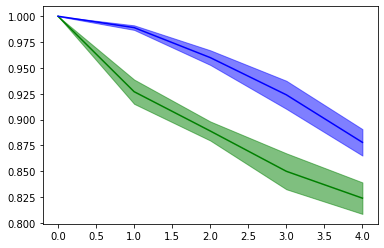

In [4]:
from scipy.stats import ttest_ind
s = 10
r = 1
n_t = 5
eps = 25
idx = np.arange(eps-1,(n_t)*eps, eps)
print(idx)
for i in range(1):
    print('\n\n\nnew det')
    low1 = s*i
    up1 = s*(i+1)
    accs1_det_all  = np.asarray(accs1_det_all_full[low1:up1])[:,idx]
    #accs2_det_all  = np.asarray(accs2_det_all_full[low1:up1])
    for j in range(1):
        print('new rand')
        low = s*r*i + s*j
        up = s*r*i + s*(j+1)
        #print(np.asarray(accs1_prob_all[low:up]))
        accs1_prob_all  = np.asarray(accs1_prob_all_full[low:up])[:,idx]
        #accs2_prob_all  = np.asarray(accs2_prob_all_full[low:up])
        #x_axis = range(len(accs1_det_all))
        x_axis = range(accs1_det_all.shape[1])
        #print("a", accs1_det_all)
        if True:
            fig, ax = plt.subplots()
            #det perc
            data = accs1_det_all
            print(accs1_det_all.shape)
            m = np.mean(data,axis=0)
            err = np.std(data, axis=0)/np.sqrt(len(data))
            print(m)
            print(err/np.sqrt(10))
            ax.plot(x_axis, m, 'g-', label='Deterministic - Task1')
            ax.fill_between(x_axis, m-err, m+err, alpha=0.5, color='g')
            #fig.show()
        if True:
            #prob perc
            data = accs1_prob_all
            m = np.mean(data,axis=0)
            err = np.std(data, axis=0)/np.sqrt(len(data))
            print(m)
            print(err/np.sqrt(10))    
            ax.plot(x_axis, m, c='b', label='Presynaptic Consolidation - Task1')
            ax.fill_between(x_axis, m-err, m+err, alpha=0.5, color='b')

        np.set_printoptions(precision=3)
        print('NoCons', int(np.mean(avg_det_all[low1:up1])*1000000)/1000000, int(1000000*np.std(avg_det_all[low1:up1]))/np.sqrt(10)/1000000)
        print('PreCons', int(1000000*np.mean(avg_prob_all[low:up]))/1000000, int(1000000*np.std(avg_prob_all[low:up]))/np.sqrt(10)/1000000)
        print(int((np.mean(avg_det_all[low1:up1])-np.mean(avg_prob_all[low:up]))*1000)/1000)
        #print(int((np.mean(accs1_det_all[:][-1])-np.mean(accs1_prob_all[low:up]))*1000)/1000)
        print(ttest_ind(avg_det_all[low1:up1], avg_prob_all[low:up]))